# 03. Azure Form Recognizer - Business Card Recognition API

In this tutorial you will learn how to use our asynchronous API to recognize business card images and extract informative fields.

For API contracts and analyze output schema details, please refer to [API Document]().

You can clone this project on Azure Notebooks to run on browser or copy of this tutorial locally to run on your mahcine.

<img src="https://docs.microsoft.com/en-us/azure/cognitive-services/form-recognizer/media/tables-example.jpg#lightbox">

> https://docs.microsoft.com/en-us/azure/cognitive-services/form-recognizer/

In [1]:
#!pip install azure-ai-formrecognizer --pre

## Install Requirements

In [2]:
import cv2
import numpy as np
import time
import requests
import colorsys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
from matplotlib.backends.backend_agg import FigureCanvasAgg
from pprint import pprint

In [3]:
ENDPOINT = 'tobereplaced'
SUBSCRIPTION_KEY = "yourkey"

In [4]:
# Sample file
SAMPLE_FILE_PATH = 'cartevisite.jpg'

In [5]:
# This value is for Content-Type header, note that if you replace the sample file, this should be matched with that file.
# Supported types: application/pdf, image/jpeg, image/png, image/tiff
SAMPLE_FILE_TYPE = 'image/jpeg'
BIZCARD_API_PATH = '/formrecognizer/v2.1-preview.1/prebuilt/businessCard/analyze'

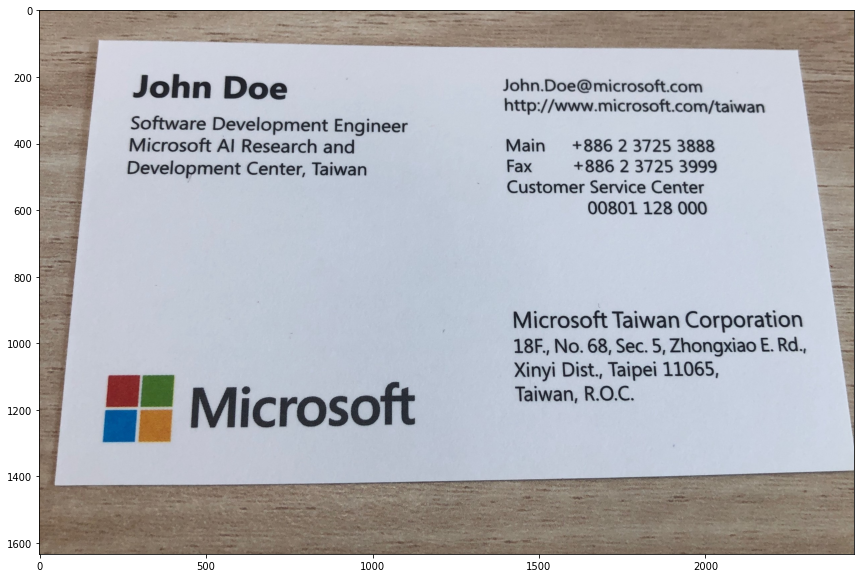

In [6]:
sample_bizcard_img = cv2.imread(SAMPLE_FILE_PATH)
plt.figure(figsize=(20, 10))
plt.imshow(sample_bizcard_img[:,:,::-1])
plt.show()

## Call Business Card Service

Since this is an asynchrous api, we first send a POST request to the service and then use GET url to get analyze result.

In [7]:
# Set POST parameters, here we use the default ones
post_params = {
    'includeTextDetails': False,
    'locale': ''
}

# Set headers for payload type and subscription key
post_headers = {
    'Content-Type': SAMPLE_FILE_TYPE,
    'Ocp-Apim-Subscription-Key': SUBSCRIPTION_KEY
}

with open(SAMPLE_FILE_PATH, 'rb') as f:
    data = f.read()

post_result = requests.post(ENDPOINT + BIZCARD_API_PATH,
                            data=data,
                            headers=post_headers,
                            params=post_params)

print('POST status [{}]'.format(post_result.status_code))

POST status [202]


After POST reqeust is sent, there will be an "Operation-Location" header in the response, indicate the analyze result location.

In [8]:
operation_location_url = post_result.headers.get('Operation-Location', '')
print('The analyze result will at this url {}.'.format(operation_location_url))

The analyze result will at this url https://formsrecognizerserger.cognitiveservices.azure.com/formrecognizer/v2.1-preview.1/prebuilt/businessCard/analyzeResults/0d2ec869-24ba-4856-8026-b22a854327c0.


When using this url to get the analyze result, we need to check the status in reponse to see if the process is done.

In [9]:
# Set GET headers for subscription key
get_headers = {
    'Ocp-Apim-Subscription-Key': SUBSCRIPTION_KEY
}

# We keep trying to GET the result until it succeeded
while True:
    get_result = requests.get(operation_location_url,
                              headers=get_headers)
  
    if get_result.status_code != 200:
        break
      
    json_result = get_result.json()
    cur_status = json_result.get('status', '')
    if cur_status == 'succeeded':
        break
    else:
        print('Status [{}]'.format(cur_status))
        time.sleep(1)

pprint(json_result)

Status [running]
Status [running]
{'analyzeResult': {'documentResults': [{'docType': 'prebuilt:businesscard',
                                        'fields': {'Addresses': {'type': 'array',
                                                                 'valueArray': [{'boundingBox': [1424,
                                                                                                 974,
                                                                                                 2311,
                                                                                                 974,
                                                                                                 2311,
                                                                                                 1183,
                                                                                                 1424,
                                                                                         

## Visualize analyze result on image

In this section we parse the json analyze result, and then draw detected labels and bounding boxes on the request image.

Note that the analyze result will be a list, which contain multiple page results, here we only take index 0 as a visualization example.

=== Results ===

ContactNames         | John Doe                       | 284 184.7 755.8 195 753.9 282.2 282.1 272
FirstName            | John                           | 284 186 514 192 513 276 284 272
LastName             | Doe                            | 553 192 755 195 754 278 552 277
JobTitles            | Software Development Engineer  | 273.9 310.2 1110 323 1109.1 383.6 272.9 370.8
Departments          | Microsoft Al Research and Development Center, Taiwan | 262.6 378 990.6 381.6 990 510.9 262 507.2
Emails               | John.Doe@microsoft.com         | 1394 203 1986 208 1986 256 1393 252
Websites             | http://www.microsoft.com/taiwan | 1393 261 2186 268 2185 317 1392 314
OtherPhones          | +886 2 3725 3888               | 1604 383 2031 383 2031 434 1604 434
Faxes                | + 886 2 3725 3999              | 1608 444 2040 444 2040 495 1608 495
MobilePhones         | 00801 128 000                  | 1648.7 571 2011 569 2011.3 621 1649 623
CompanyNames         |

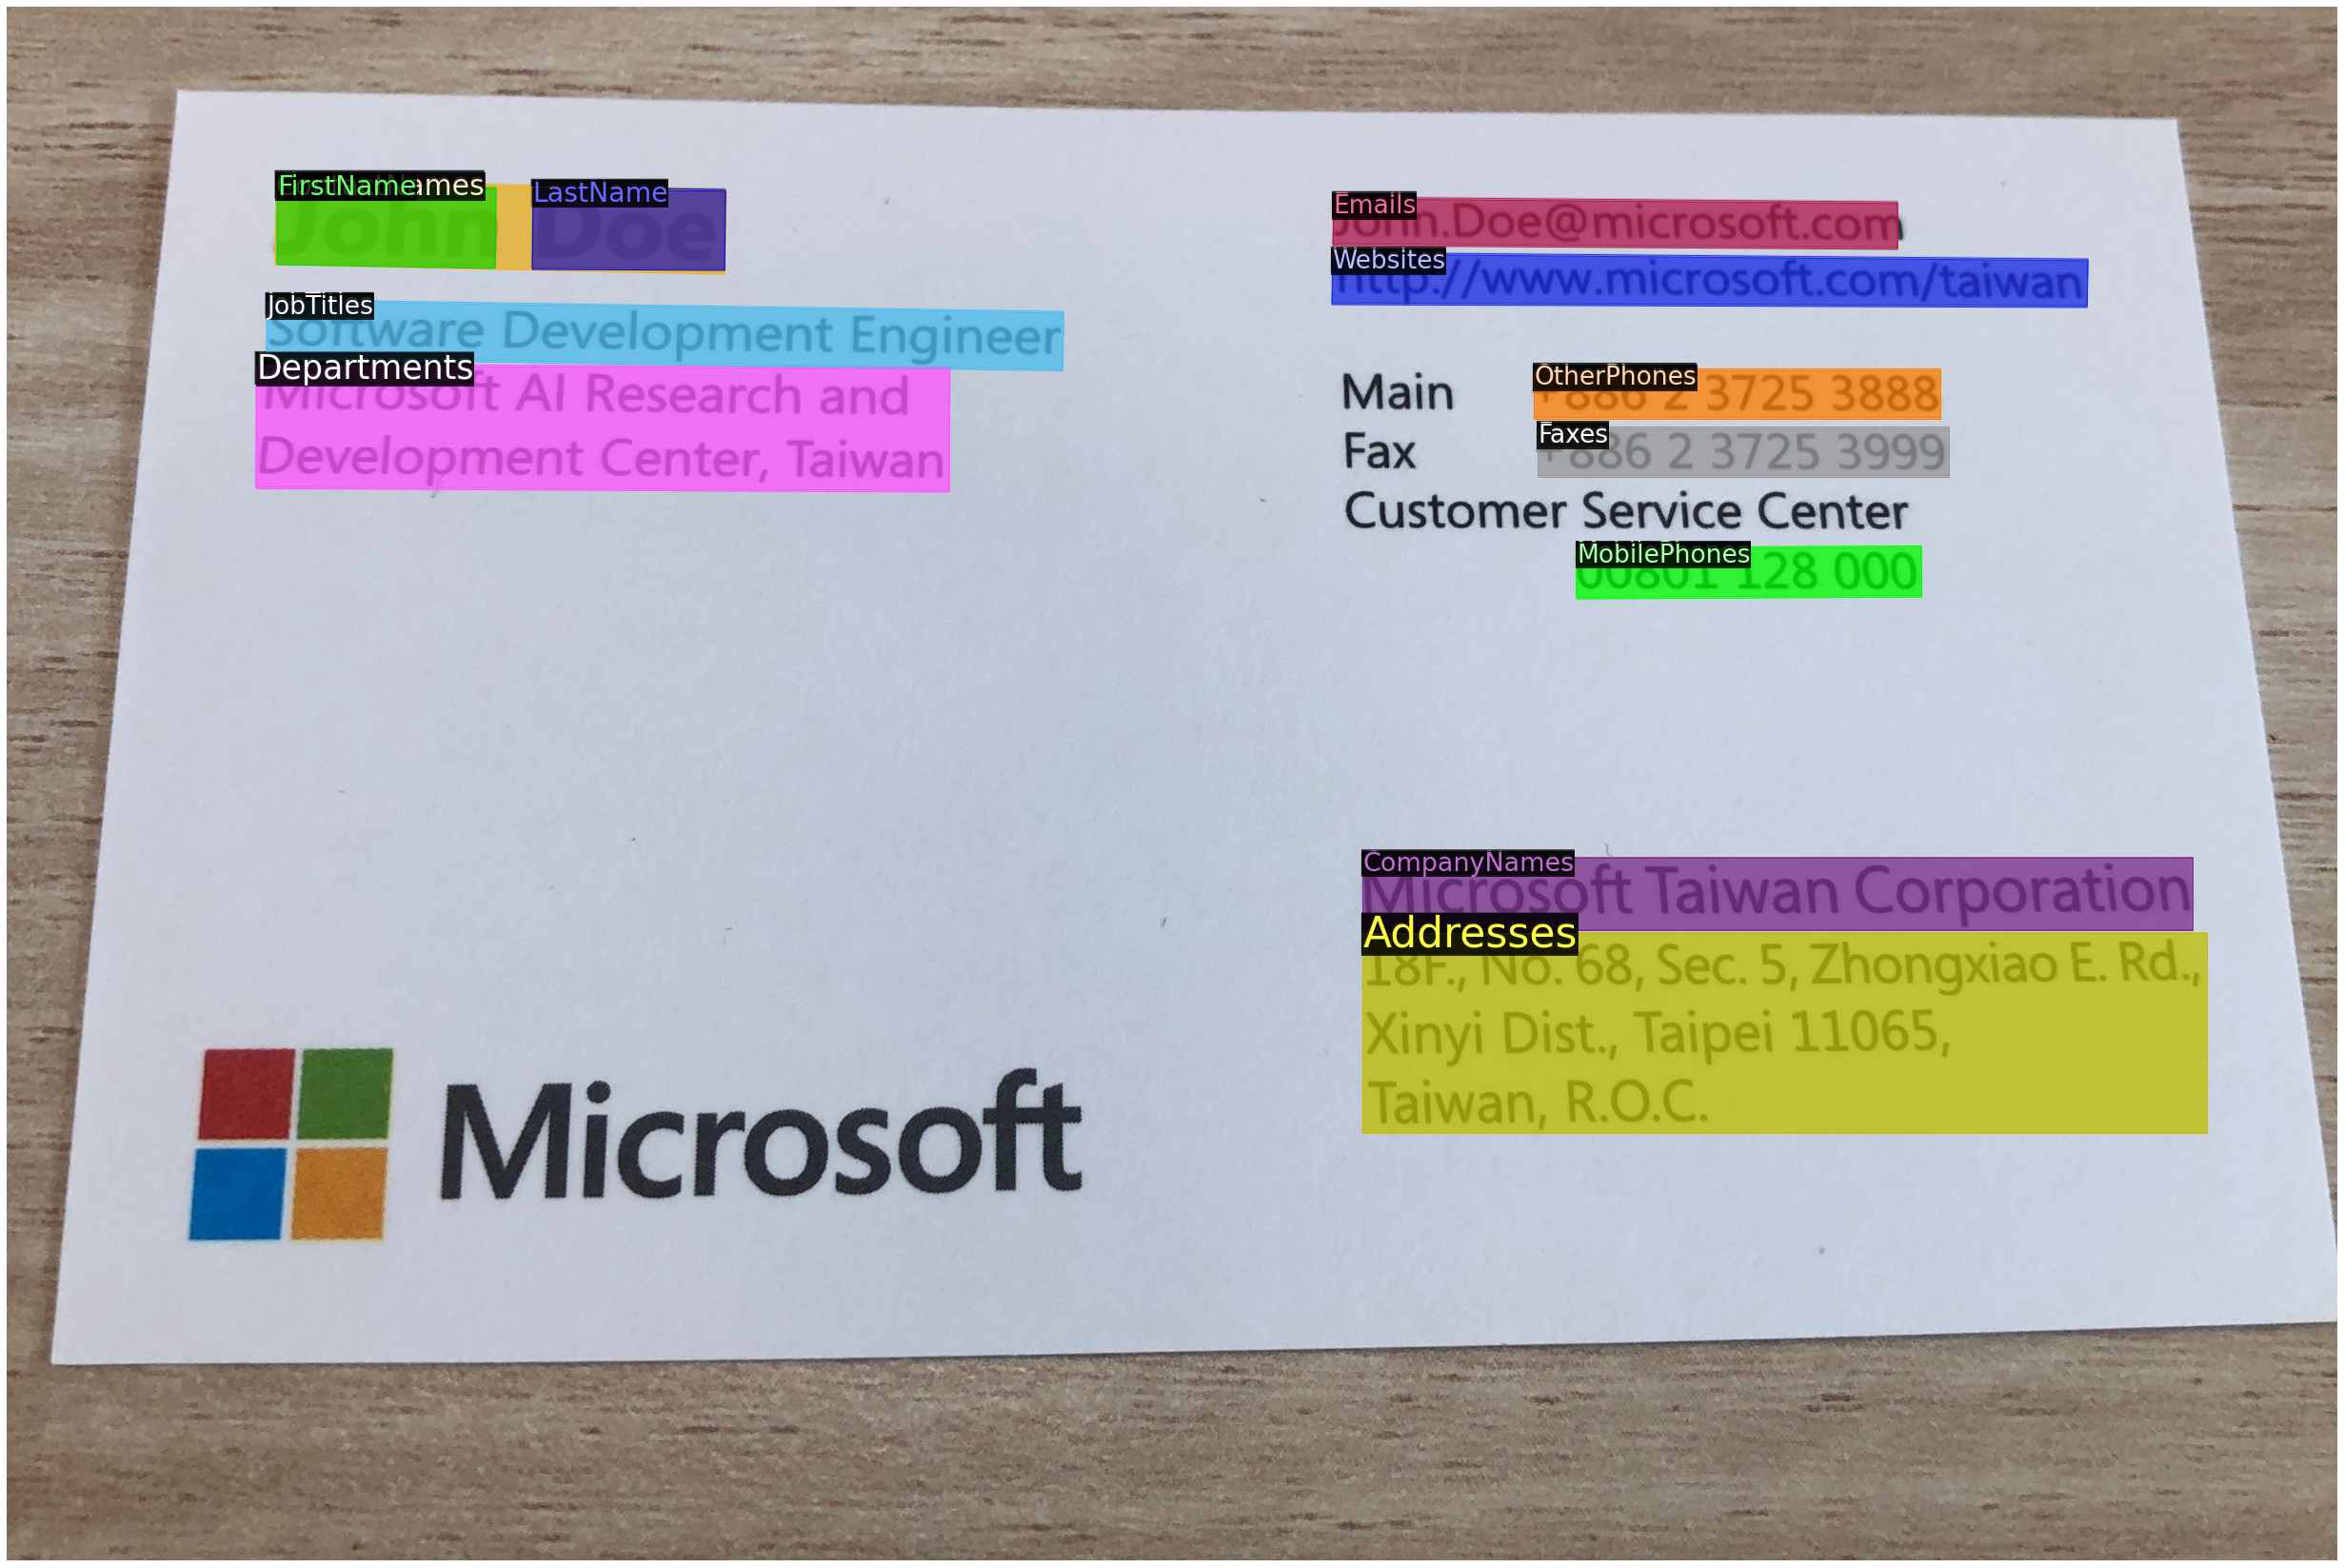

In [10]:
class BizcardAnalyzeResultParser(object):
    BIZCARD_LABEL_DICT = {
        'Other': 1,
        'ContactNames': 2,
        'CompanyNames': 3,
        'CompanyLogo': 4,
        'JobTitles': 5,
        'WorkPhones': 6,
        'Faxes': 7,
        'OtherPhones': 8,
        'Addresses': 9,
        'MobilePhones': 10,
        'Departments': 11,
        'Emails': 12,
        'Websites': 13,
        'FirstName': 14,
        'LastName': 15
    }

    def __init__(self, words):
        self.words = words

    @classmethod
    def from_json(cls, data):
        if data.get('fields', None) is None:
            raise ValueError('Wrong schema.')

        item_list = []
        words = []
        data = data['fields']
        for key in data.keys():
            label_id = cls.BIZCARD_LABEL_DICT.get(key, -1)
            if data[key] is None or label_id == -1:
                continue
            cls._parse(data[key], label_id, words)
        return cls(words)

    @classmethod
    def _parse(cls, data, label, words):
        _type = data.get('type', '')
        if not _type:
            return

        if _type == 'array':
            for instance in data.get('valueArray', []):
                cls._parse(instance, label, words)

        if _type == 'object':
            if data.get('boundingBox', []):
                words.append(Word(bbox=data.get('boundingBox', []),
                                  text=data.get('text', ''),
                                  confidence=data.get('confidence', 1.0),
                                  label=label,
                                  word_table=cls.BIZCARD_LABEL_DICT))
            for sub_label in data.get('valueObject', {}).keys():
                cls._parse(data['valueObject'][sub_label],
                           cls.BIZCARD_LABEL_DICT.get(sub_label, -1),
                           words)

        if _type in ('string', 'phoneNumber', 'date', 'number', 'time'):
            text = data.get('value' + _type[0].upper() + _type[1:], '')
            if not text:
                text = data.get('text', '')
            words.append(Word(bbox=data.get('boundingBox', []),
                         text=text,
                         confidence=data.get('confidence', 1.0),
                         label=label,
                         word_table=cls.BIZCARD_LABEL_DICT))


def find_label_text(label, label_dict):
    for key in label_dict.keys():
        if label == label_dict[key]:
            return key
    return ''


class Word(object):
    def __init__(self, bbox, text, label=0, confidence=1.0, word_table={}):
        self.bbox = BoundingBox(bbox)
        self.text = text
        self.label = label
        self.confidence = confidence
        self.word_table = word_table

    def __str__(self):
        return '{:<20} | {:<30} | {}'.format(
            find_label_text(self.label, self.word_table), self.text, str(self.bbox))

    @property
    def label_str(self):
        return find_label_text(self.label, self.word_table)


class BoundingBox(object):
    def __init__(self, l):
        if not isinstance(l, list):
            raise ValueError('wrong bbox.')
        self._bbox = l

    def __str__(self):
        return ' '.join([str(val) for val in self._bbox])

    @property
    def val(self):
        return self._bbox

    @property
    def min_x(self):
        return min(self._bbox[::2])

    @property
    def max_x(self):
        return max(self._bbox[::2])

    @property
    def min_y(self):
        return min(self._bbox[1::2])

    @property
    def max_y(self):
        return max(self._bbox[1::2])


_COLORS = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.600, 0.600, 0.600,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        1.000, 0.333, 1.000,
        0.700, 0.100, 0.300,
        0.100, 0.167, 0.900,
        0.000, 0.833, 0.000,
        0.000, 0.000, 0.833,
    ]
).astype(np.float32).reshape(-1, 3)


class Visualizer:
    def __init__(self, img_rgb):
        self.img = np.asarray(img_rgb).clip(0, 255).astype(np.uint8)
        self.height =  self.img.shape[0]
        self.width = self.img.shape[1]

        self.fig = plt.figure(figsize=(20, 10), frameon=False)
        self.dpi = self.fig.get_dpi() * 1.0
        self.fig.set_size_inches(
            (self.width + 1e-2) / self.dpi,
            (self.height + 1e-2) / self.dpi,
        )
        self.canvas = FigureCanvasAgg(self.fig)
        self.ax = self.fig.add_axes([0.0, 0.0, 1.0, 1.0])
        self.ax = self.fig.gca()
        self.ax.axis("off")
        self.ax.set_xlim(0.0, self.width)
        self.ax.set_ylim(self.height)

        # too small texts are useless, therefore clamp to 9
        self._default_font_size = max(
            np.sqrt(self.height * self.width) // 90, 10)

    def draw(self, words, alpha=0.5):
        assigned_colors = [_COLORS[words[i].label] for i in range(len(words))]

        for i in range(len(words)):
            color = assigned_colors[i]
            self.draw_polygon(np.asarray(words[i].bbox.val).reshape(-1, 2), color, alpha=alpha)

            if words[i].label_str != '':
                x0 = words[i].bbox.min_x
                y0 = words[i].bbox.min_y
                x1 = words[i].bbox.max_x
                y1 = words[i].bbox.max_y

                height_ratio = (y1 - y0) / np.sqrt(self.height * self.width)
                lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
                font_size = (
                        np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                        * 1.0
                        * self._default_font_size)
                
                self.draw_text(
                    words[i].label_str,
                    (x0, y0 - int(0.1 * (y1 - y0))),
                    color=lighter_color,
                    horizontal_alignment='left',
                    font_size=font_size)

    def draw_text(self, text, position, font_size=None, color="g", 
                  horizontal_alignment="center", rotation=0):
        if not font_size:
            font_size = self._default_font_size

        # since the text background is dark, we don't want the text to be dark
        color = np.maximum(list(mplc.to_rgb(color)), 0.2)
        color[np.argmax(color)] = max(0.8, np.max(color))

        x, y = position
        self.ax.text(
            x,
            y,
            text,
            size=font_size,
            family="sans-serif",
            bbox={"facecolor": "black", "alpha": 0.8, "pad": 0.7, "edgecolor": "none"},
            verticalalignment="top",
            horizontalalignment=horizontal_alignment,
            color=color,
            zorder=10,
            rotation=rotation)

    def draw_polygon(self, segment, color, edge_color=None, alpha=0.3):
        if edge_color is None:
            # make edge color darker than the polygon color
            if alpha > 0.8:
                edge_color = self._change_color_brightness(color, brightness_factor=-0.7)
            else:
                edge_color = color
        edge_color = mplc.to_rgb(edge_color) + (1,)

        polygon = mpl.patches.Polygon(
            segment,
            fill=True,
            facecolor=mplc.to_rgb(color) + (alpha,),
            edgecolor=edge_color,
            linewidth=max(self._default_font_size // 15, 1),
        )
        self.ax.add_patch(polygon)

    def _change_color_brightness(self, color, brightness_factor):
        assert brightness_factor >= -1.0 and brightness_factor <= 1.0
        color = mplc.to_rgb(color)
        polygon_color = colorsys.rgb_to_hls(*mplc.to_rgb(color))
        modified_lightness = polygon_color[1] + (brightness_factor * polygon_color[1])
        modified_lightness = 0.0 if modified_lightness < 0.0 else modified_lightness
        modified_lightness = 1.0 if modified_lightness > 1.0 else modified_lightness
        modified_color = colorsys.hls_to_rgb(polygon_color[0], modified_lightness, polygon_color[2])
        return modified_color

    def get_image(self):
        img = self.img
        canvas = self.canvas
        s, (width, height) = canvas.print_to_buffer()
        buffer = np.frombuffer(s, dtype="uint8")
        
        img = cv2.resize(img, (width, height))
        img_rgba = buffer.reshape(height, width, 4)
        rgb, alpha = np.split(img_rgba, [3], axis=2)

        try:
            import numexpr as ne  # fuse them with numexpr

            visualized_image = ne.evaluate("img * (1 - alpha / 255.0) + rgb * (alpha / 255.0)")
        except ImportError:
            alpha = alpha.astype("float32") / 255.0
            visualized_image = img * (1 - alpha) + rgb * alpha

        visualized_image = visualized_image.astype("uint8")
        return visualized_image


viz = Visualizer(sample_bizcard_img[:,:,::-1])

# documentResults will be a list that may contain multi-page results,
# at here we use index 0 as a visualization example
bizcard_parse_result = BizcardAnalyzeResultParser.from_json(
    json_result.get('analyzeResult', {}).get('documentResults', [])[0])

print("=== Results ===")
print()

for word in bizcard_parse_result.words:
    print(word)

print("\n=== Image ===")
viz.draw(bizcard_parse_result.words)
view = viz.get_image()
plt.imshow(view, aspect='auto')
plt.show()

In [11]:
for word in bizcard_parse_result.words:
    print(word)

ContactNames         | John Doe                       | 284 184.7 755.8 195 753.9 282.2 282.1 272
FirstName            | John                           | 284 186 514 192 513 276 284 272
LastName             | Doe                            | 553 192 755 195 754 278 552 277
JobTitles            | Software Development Engineer  | 273.9 310.2 1110 323 1109.1 383.6 272.9 370.8
Departments          | Microsoft Al Research and Development Center, Taiwan | 262.6 378 990.6 381.6 990 510.9 262 507.2
Emails               | John.Doe@microsoft.com         | 1394 203 1986 208 1986 256 1393 252
Websites             | http://www.microsoft.com/taiwan | 1393 261 2186 268 2185 317 1392 314
OtherPhones          | +886 2 3725 3888               | 1604 383 2031 383 2031 434 1604 434
Faxes                | + 886 2 3725 3999              | 1608 444 2040 444 2040 495 1608 495
MobilePhones         | 00801 128 000                  | 1648.7 571 2011 569 2011.3 621 1649 623
CompanyNames         | Microsoft Taiwan